In [2]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import time
from IPython.display import Image
from fatiando.vis import myv, mpl
from fatiando.gravmag import tesseroid
from fatiando import gridder, utils
from fatiando.inversion import Smoothness2D
from tesseroid_mesh import TesseroidRelief
from crust1 import fetch_crust1
from moho import MohoGravityInversion

In [3]:
area = (-85, -30, -60, 15)
crust1 = fetch_crust1('../data/crust1.0.tar.gz').cut(area)

In [4]:
reference = -30e3
mean_crust_density = crust1.density[5:8].mean(0)
moho_density_contrast = mean_crust_density - 3200
moho_density_contrast[-crust1.moho_depth > reference] *= -1

In [5]:
bm = Basemap(projection='cyl', llcrnrlon=area[0], urcrnrlon=area[1], llcrnrlat=area[2], urcrnrlat=area[3],
             lon_0=0.5*(area[0] + area[1]), lat_0=0.5*(area[2] + area[3]), resolution='c')
x, y = bm(crust1.lon, crust1.lat)

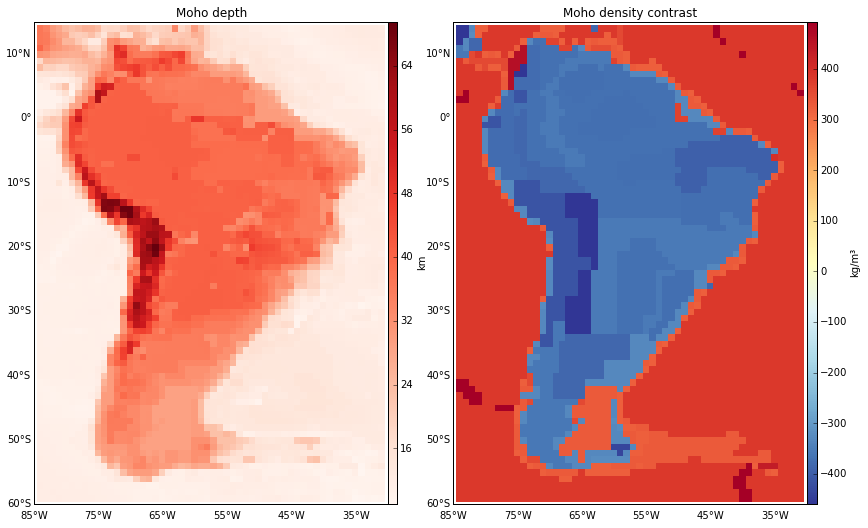

In [6]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.title('Moho depth')
bm.pcolor(x, y, 0.001*crust1.moho_depth, cmap='Reds')
plt.colorbar(pad=0, aspect=50).set_label('km')
bm.drawmeridians(range(area[0], area[1], 10), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(range(area[2], area[3], 10), labels=[1, 0, 0, 0], linewidth=0)
plt.subplot(1, 2, 2)
plt.title('Moho density contrast')
bm.pcolor(x, y, moho_density_contrast, cmap='RdYlBu_r')
plt.colorbar(pad=0, aspect=50).set_label(u'kg/m³')
bm.drawmeridians(range(area[0], area[1], 10), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(range(area[2], area[3], 10), labels=[1, 0, 0, 0], linewidth=0)
plt.tight_layout()

In [21]:
lon, lat = crust1.lon.ravel(), crust1.lat.ravel()
height = 20e3*np.ones_like(lon)
shape = crust1.density.shape[1:]
shape

(75, 55)

In [22]:
model = TesseroidRelief(area, shape, relief=-crust1.moho_depth.ravel(), reference=reference, 
                        props={'density': moho_density_contrast.ravel()})

In [23]:
ncpu = multiprocessing.cpu_count()
ncpu

4

In [24]:
data = tesseroid.gz(lon, lat, height, model, njobs=ncpu)

In [34]:
noisy_data = utils.contaminate(data, 5)

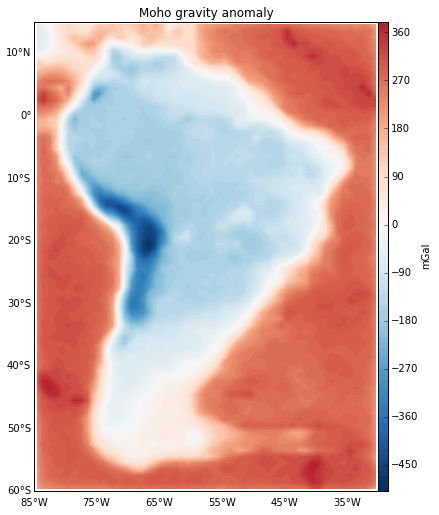

In [35]:
plt.figure(figsize=(6, 7))
plt.title('Moho gravity anomaly')
amp = np.abs([data.min(), data.max()]).max()
bm.contourf(x, y, noisy_data.reshape(shape), 100, cmap='RdBu_r', vmin=-amp, vmax=amp)
plt.colorbar(pad=0, aspect=50).set_label('mGal')
bm.drawmeridians(range(area[0], area[1], 10), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(range(area[2], area[3], 10), labels=[1, 0, 0, 0], linewidth=0)
plt.tight_layout()

In [36]:
mesh = model.copy(deep=True)
initial = np.ones(mesh.size)*(reference - 10e3)
solver = MohoGravityInversion(lon, lat, height, data, mesh, njobs=ncpu)
solver.config('newton', tol=0.2, maxit=10, initial=initial)

In [37]:
t0 = time.time()
solver.fit()
print('Computation time: {} s'.format(time.time() - t0))

Computation time: 109.434782028 s


/home/leo/src/fatiando/fatiando/inversion/optimization.py:184: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)


In [44]:
residuals = solver.residuals()
predicted = solver.predicted()
moho = solver.estimate_
residuals.mean(), residuals.std()

(0.00029309200917396525, 0.45273797272420041)

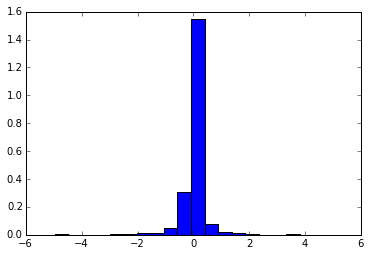

In [49]:
plt.figure()
_ = plt.hist(residuals, 20, normed=True)

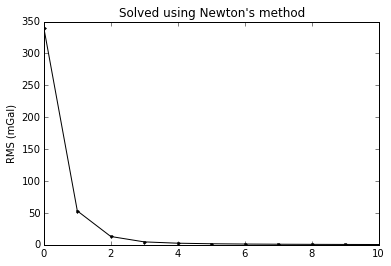

In [47]:
plt.figure()
plt.title('Solved using {}'.format(solver.stats_['method']))
rms = np.sqrt(solver.stats_['objective'])/np.sqrt(solver.ndata)
plt.plot(rms, '.k-')
plt.ylabel('RMS (mGal)')

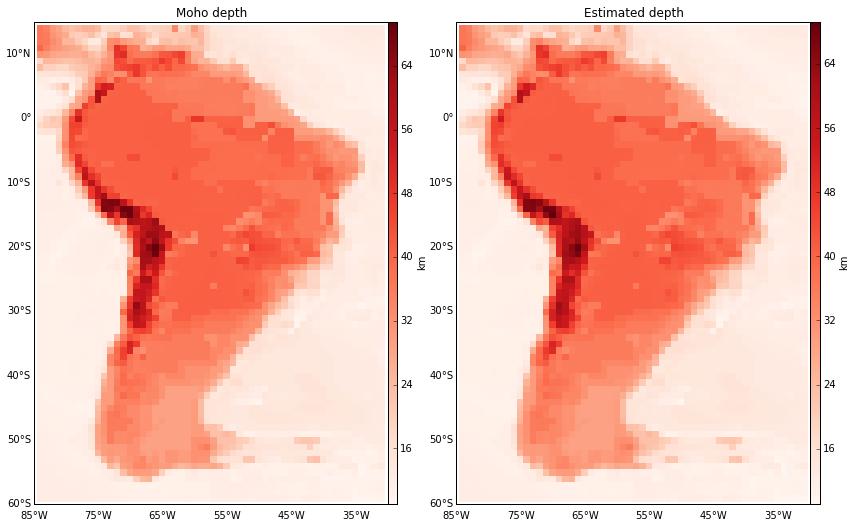

In [43]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.title('Moho depth')
bm.pcolor(x, y, 0.001*crust1.moho_depth, cmap='Reds')
plt.colorbar(pad=0, aspect=50).set_label('km')
bm.drawmeridians(range(area[0], area[1], 10), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(range(area[2], area[3], 10), labels=[1, 0, 0, 0], linewidth=0)
plt.subplot(1, 2, 2)
plt.title('Estimated depth')
bm.pcolor(x, y, -0.001*solver.p_.reshape(shape), cmap='Reds')
plt.colorbar(pad=0, aspect=50).set_label(u'km')
bm.drawmeridians(range(area[0], area[1], 10), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(range(area[2], area[3], 10), labels=[1, 0, 0, 0], linewidth=0)
plt.tight_layout()

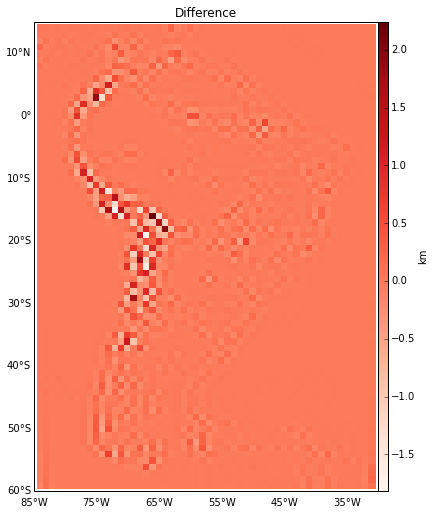

In [50]:
plt.figure(figsize=(6, 7))
plt.title('Difference')
bm.pcolor(x, y, 0.001*(crust1.moho_depth - -solver.p_.reshape(shape)), cmap='Reds')
plt.colorbar(pad=0, aspect=50).set_label('km')
bm.drawmeridians(range(area[0], area[1], 10), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(range(area[2], area[3], 10), labels=[1, 0, 0, 0], linewidth=0)
plt.tight_layout()